### S&P500 Portfolio

In [105]:
import yfinance as yf
import pandas as pd

start_date = '2015-01-01'
end_date = '2024-03-16'

In [106]:
import FinanceDataReader as fdr

sp500 = fdr.StockListing('S&P500')
sp500

Symbol                  Name                  Sector  \
0      MMM                    3M             Industrials   
1      AOS           A. O. Smith             Industrials   
2      ABT                Abbott             Health Care   
3     ABBV                AbbVie             Health Care   
4      ACN             Accenture  Information Technology   
..     ...                   ...                     ...   
498    YUM           Yum! Brands  Consumer Discretionary   
499   ZBRA    Zebra Technologies  Information Technology   
500    ZBH         Zimmer Biomet             Health Care   
501   ZION  Zions Bancorporation              Financials   
502    ZTS                Zoetis             Health Care   

                               Industry  
0              Industrial Conglomerates  
1                     Building Products  
2                 Health Care Equipment  
3                         Biotechnology  
4        IT Consulting & Other Services  
..                                  ...  
498                         Restaurants  
499  Electronic Equipment & Instruments  
500               Health Care Equipment  
501                      Regional Banks  
502                     Pharmaceuticals  

[503 rows x 4 columns]

In [107]:
symbol = sp500['Symbol']

In [144]:
data = yf.download(symbol.values.tolist(), start=start_date, end=end_date)['Close']

[*********************100%%**********************]  503 of 503 completed

2 Failed downloads:
['BFB', 'BRKB']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [145]:
data.dropna(axis = 1, inplace = True)

data_test = data.loc['2023':]
data = data.loc[:'2022']

<Axes: xlabel='Ticker', ylabel='Ticker'>

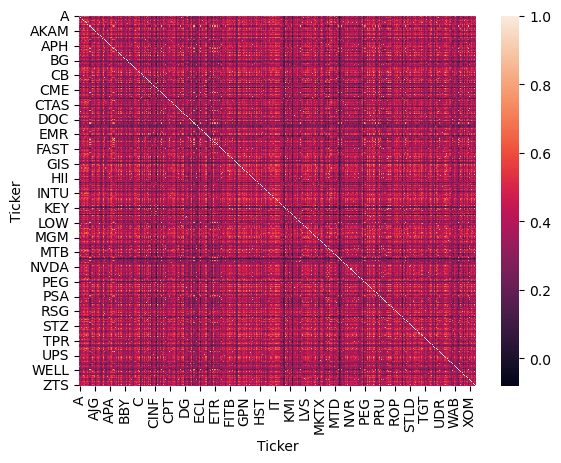

In [113]:
import seaborn as sns

sns.heatmap(data.pct_change().corr())

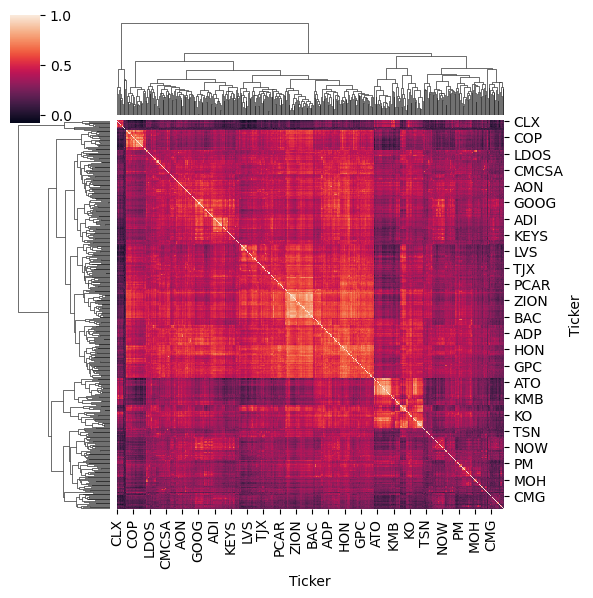

In [114]:
import matplotlib.pyplot as plt
sns.clustermap(
    data.pct_change().corr(),
    figsize = (6, 6)
)
plt.show()

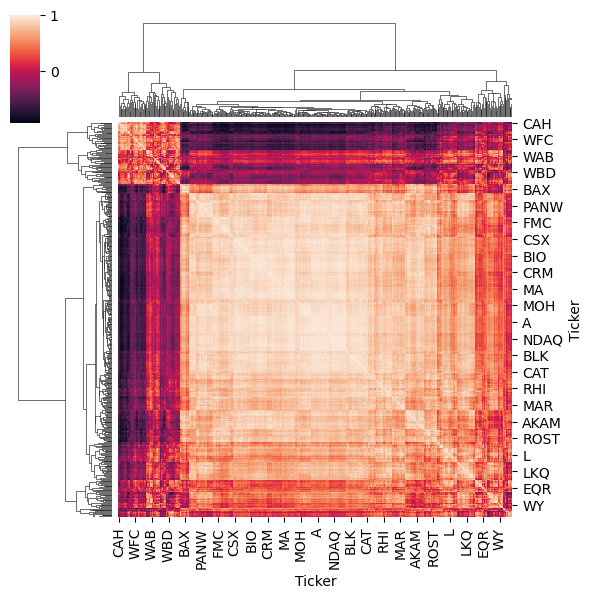

In [115]:
sns.clustermap(
    data.corr(),
    figsize = (6, 6)
)
plt.show()

In [116]:
from FinancialMachineLearning.utils.stats import *
from FinancialMachineLearning.machine_learning.clustering import *

eVal0, eVec0 = getPCA(data.pct_change().corr())

In [117]:
q = 10
eMax0, var0 = find_max_eval(np.diag(eVal0), q, bWidth = 0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

In [118]:
x = np.random.normal(size = (10000, 1000))

pdf0 = marcenko_pastur_prob_distribution(
    var0, 
    q = x.shape[0]/float(x.shape[1]), 
    pts = 1000
)

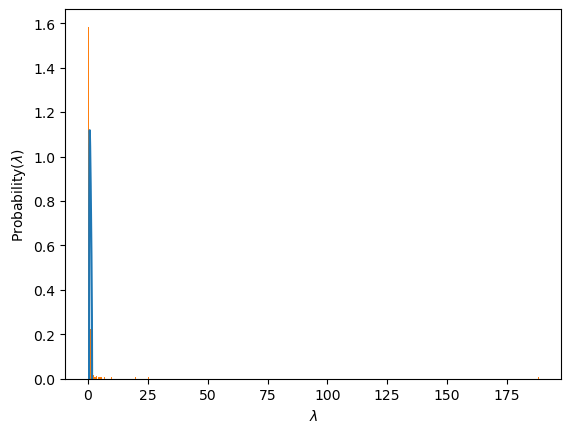

In [119]:
plt.plot(pdf0, label = "Marcenko-pastur Distribution")
plt.hist(
    np.diag(eVal0), density = True, bins=500, label = "Empirical Distribution", edgecolor = 'none'
)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Probability($\lambda$)')
plt.grid(False)
plt.show()

In [120]:
corr1 = denoise_constant_residual_eigenvalue(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corr1)

In [121]:
eMax1, var1 = find_max_eval(np.diag(eVal1), q, bWidth = 0.01)
nFacts1 = eVal1.shape[0] - np.diag(eVal1)[::-1].searchsorted(eMax1)

In [122]:
pdf1 = marcenko_pastur_prob_distribution(
    var1, 
    q = x.shape[0] / float(x.shape[1]), 
    pts = 1000
)

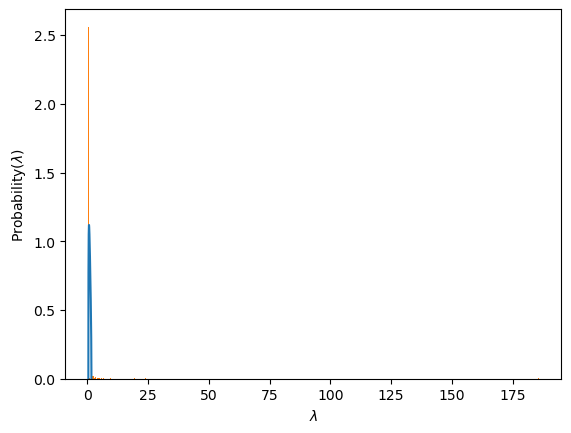

In [123]:
plt.plot(pdf1, label = "Marcenko-pastur Distribution")
plt.hist(
    np.diag(eVal1), density = True, bins=500, label = "Empirical Distribution", edgecolor = 'none'
)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Probability($\lambda$)')
plt.grid(False)
plt.show()

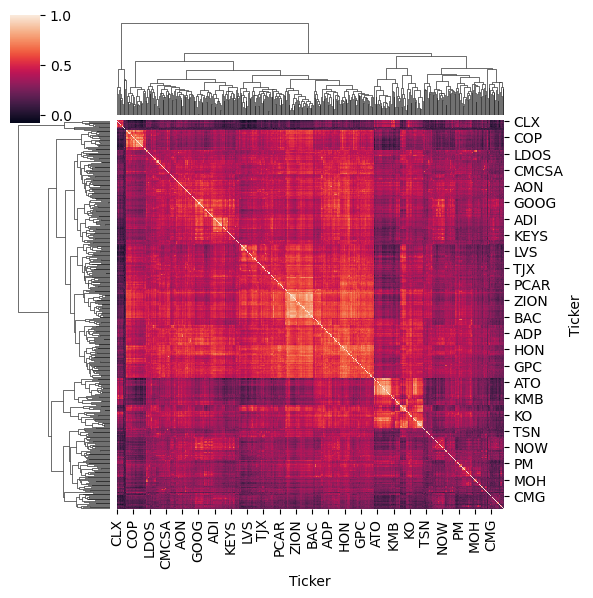

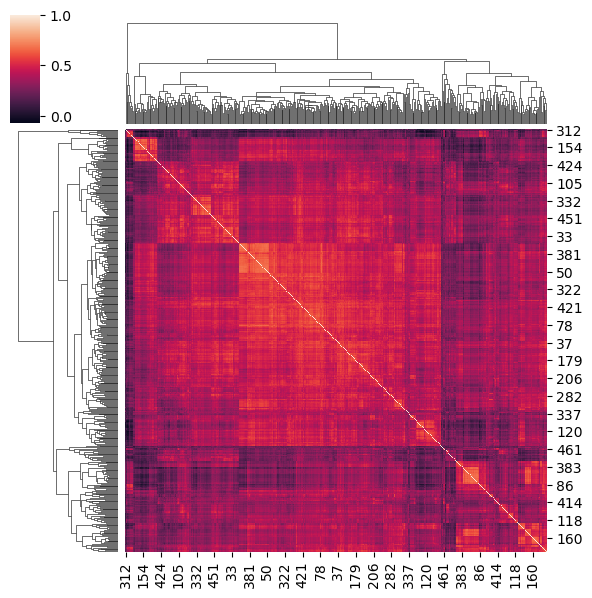

In [124]:
sns.clustermap(
    data.pct_change().corr(),
    figsize = (6, 6)
)
plt.show()
sns.clustermap(corr1, figsize = (6, 6))
plt.show()

In [125]:
from FinancialMachineLearning.machine_learning.clustering import clusterKMeansBase, clusterKMeansTop

In [126]:
corr1 = pd.DataFrame(
    corr1,
    index = data.pct_change().corr().index,
    columns = data.pct_change().corr().columns
)

In [127]:
cov1 = correlation_to_covariance(corr1, np.diag(data.pct_change().cov()) ** 0.5)

In [130]:
corr_kmeans, clusters_kmeans, silh_coef_kmeans = clusterKMeansBase(
    corr1, maxNumClusters = 10, n_init = 10
)

<Axes: xlabel='Ticker', ylabel='Ticker'>

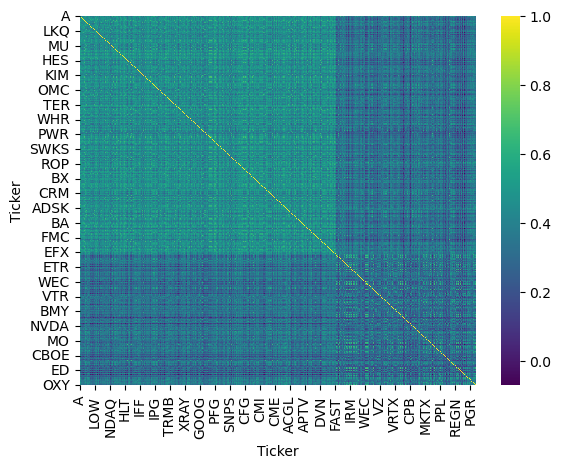

In [131]:
sns.heatmap(
    corr_kmeans,
    cmap = 'viridis'
)

In [133]:
origin_corr = data.pct_change().corr()

corr_kmean_origin, cluster, silh = clusterKMeansBase(
    origin_corr, maxNumClusters = 10, n_init = 10
)

In [134]:
corr_kmean_top, clusters_kmean_top, silh_coef_kmean_top = clusterKMeansTop(
    corr1, maxNumClusters = 10, n_init = 10
)

clstrs length:2
best clustr:2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[1] clstrs len:2


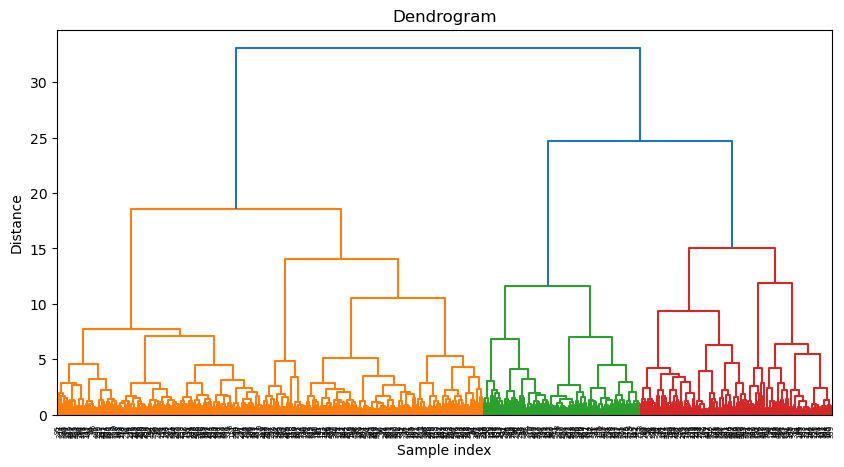

In [135]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(corr1, method = 'ward')

plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [146]:
cluster1_ret = data_test.pct_change()[clusters_kmean_top[0]].fillna(0).mean(axis = 1)

In [147]:
cluster2_ret = data_test.pct_change()[clusters_kmean_top[1]].fillna(0).mean(axis = 1)

<Axes: xlabel='Date'>

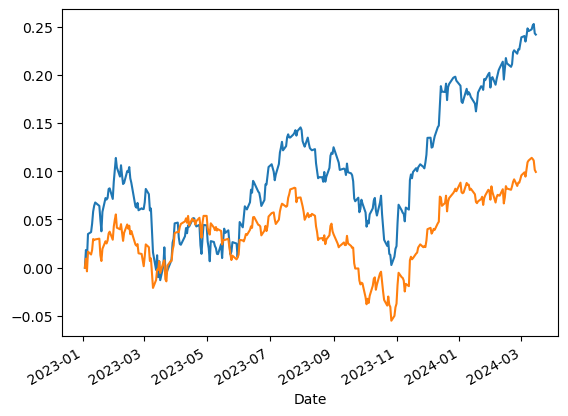

In [148]:
cluster1_ret.cumsum().plot()
cluster2_ret.cumsum().plot()

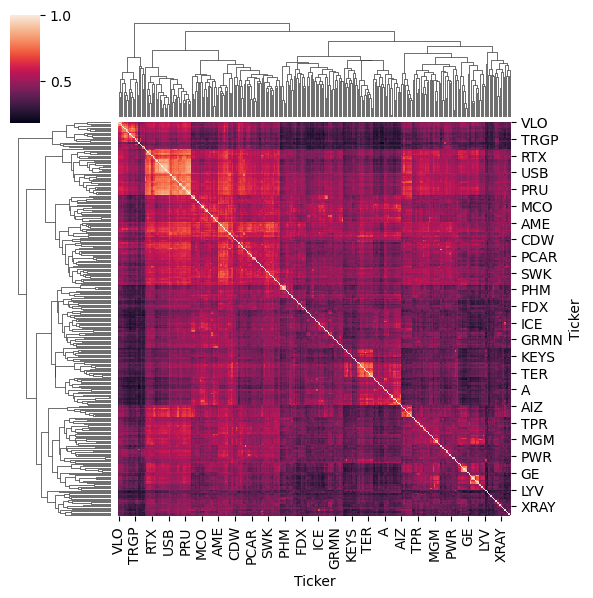

In [150]:
sns.clustermap(
    data.pct_change()[clusters_kmean_top[0]].fillna(0).corr(),
    figsize = (6, 6)
)

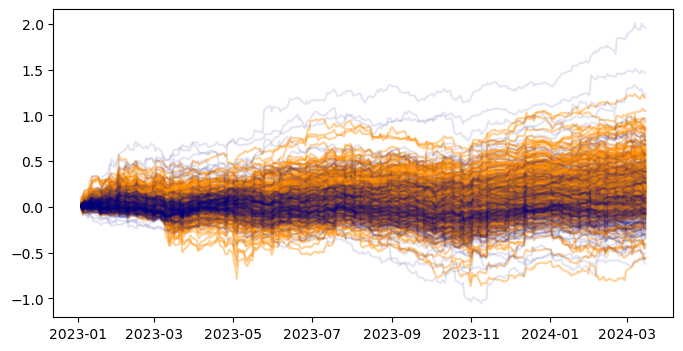

In [151]:
plt.figure(figsize = (8, 4))
plt.plot(
    data_test.pct_change()[clusters_kmean_top[0]].cumsum(), 
    color = 'darkorange',
    alpha = 0.4,
    label = 'cluster 1'
)
plt.plot(
    data_test.pct_change()[clusters_kmean_top[1]].cumsum(),
    color = 'navy',
    alpha = 0.1,
    label = 'cluster 2'
)
plt.show()

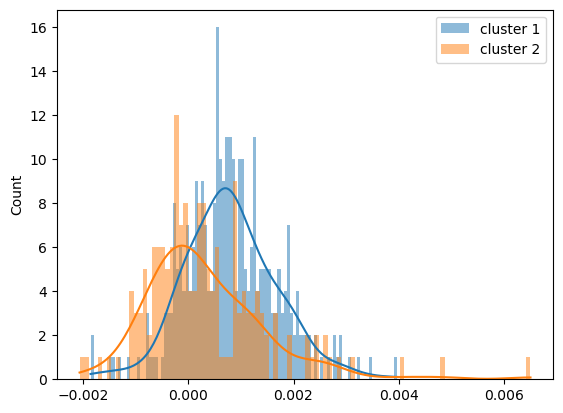

In [157]:
sns.histplot(
    data_test.pct_change()[clusters_kmean_top[0]].mean(axis = 0),
    edgecolor = 'none',
    kde = True,
    bins = 100,
    label = 'cluster 1'
)
sns.histplot(
    data_test.pct_change()[clusters_kmean_top[1]].mean(axis = 0),
    edgecolor = 'none',
    kde = True,
    bins = 100,
    label = 'cluster 2'
)
plt.legend()
plt.show()

In [190]:
momentum1 = (data[clusters_kmean_top[0]] - data[clusters_kmean_top[0]].rolling(window = 60).mean()) / data[clusters_kmean_top[0]].rolling(window = 60).std()
momentum2 = (data[clusters_kmean_top[1]] - data[clusters_kmean_top[1]].rolling(window = 60).mean()) / data[clusters_kmean_top[1]].rolling(window = 60).std()

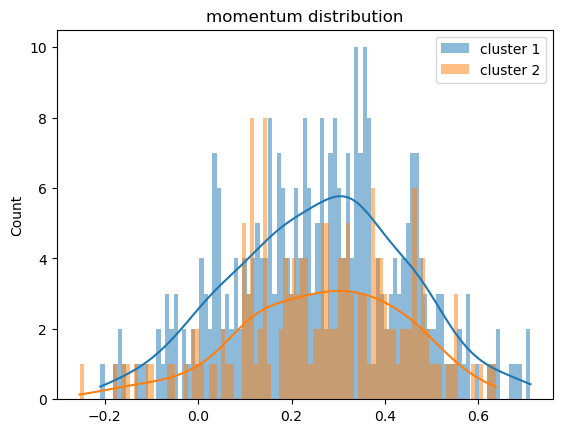

In [192]:
sns.histplot(
    momentum1.mean(axis = 0),
    bins = 100,
    kde = True,
    edgecolor = 'none',
    label = 'cluster 1'
)
sns.histplot(
    momentum2.mean(axis = 0),
    bins = 100,
    kde = True,
    edgecolor = 'none',
    label = 'cluster 2'
)
plt.legend()
plt.title('momentum distribution')
plt.show()

In [194]:
momentum2

Ticker          ABBV       ABT      ADBE       AEE       AEP      AKAM  \
Date                                                                     
2015-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2015-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
2015-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
2015-01-07       NaN       NaN       NaN       NaN       NaN       NaN   
2015-01-08       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-12-23  1.186875  1.248995  0.975602  1.332209  1.083337 -0.921032   
2022-12-27  1.149775  1.303789  0.791846  1.444005  1.171197 -0.868042   
2022-12-28  1.033264  1.085026  0.431175  1.204781  0.942255 -0.865748   
2022-12-29  1.037538  1.624112  0.870703  1.301850  1.051367 -0.573712   
2022-12-30  0.896652  1.447432  0.789076  1.032399  0.801617 -0.661327   

Ticker          AMCR       AMD      AMGN       AMT  ...      VTRS        VZ  \
Date                                                ...                       
2015-01-02       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2015-01-05       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2015-01-06       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2015-01-07       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2015-01-08       NaN       NaN       NaN       NaN  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2022-12-23  0.769145 -0.242886 -0.202969  0.387336  ...  0.733071  0.860382   
2022-12-27  0.777752 -0.434182 -0.277651  0.258944  ...  0.746127  1.672484   
2022-12-28  0.449331 -0.531113 -0.433551  0.200665  ...  0.577303  1.241860   
2022-12-29  0.627252 -0.179388 -0.375374  0.704153  ...  0.811302  1.745977   
2022-12-30  0.405815 -0.179043 -0.453611  0.366873  ...  0.784839  1.892277   

Ticker           WBA       WBD       WEC      WELL        WM       WMT  \
Date                                                                     
2015-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2015-01-05       NaN       NaN       NaN       NaN       NaN       NaN   
2015-01-06       NaN       NaN       NaN       NaN       NaN       NaN   
2015-01-07       NaN       NaN       NaN       NaN       NaN       NaN   
2015-01-08       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-12-23  0.329764 -1.931453  0.741178  0.197747 -0.448899  0.202933   
2022-12-27  0.209336 -1.795779  0.833494  0.390104 -0.376139  0.181026   
2022-12-28 -0.034190 -1.985014  0.611386  0.140883 -0.857535 -0.192613   
2022-12-29 -0.089611 -1.475947  0.676310  0.361254 -0.471510 -0.090818   
2022-12-30 -0.147695 -1.383283  0.296938  0.285308 -0.931419 -0.166286   

Ticker           WST       XEL  
Date                            
2015-01-02       NaN       NaN  
2015-01-05       NaN       NaN  
2015-01-06       NaN       NaN  
2015-01-07       NaN       NaN  
2015-01-08       NaN       NaN  
...              ...       ...  
2022-12-23 -0.172086  1.226292  
2022-12-27 -0.026887  1.342145  
2022-12-28 -0.458203  1.054631  
2022-12-29  0.238621  1.148775  
2022-12-30 -0.047328  0.880076  

[2014 rows x 169 columns]

In [199]:
top10_index1 = momentum1.mean(axis = 0).sort_values(ascending = False)[:10].index
mid10_index1 = momentum1.mean(axis = 0).sort_values(ascending = False)[145:155].index
bottom10_index1 = momentum1.mean(axis = 0).sort_values(ascending = False)[-10:].index

top10_index2 = momentum2.mean(axis = 0).sort_values(ascending = False)[:10].index
mid10_index2 = momentum2.mean(axis = 0).sort_values(ascending = False)[80:90].index
bottom10_index2 = momentum2.mean(axis = 0).sort_values(ascending = False)[-10:].index

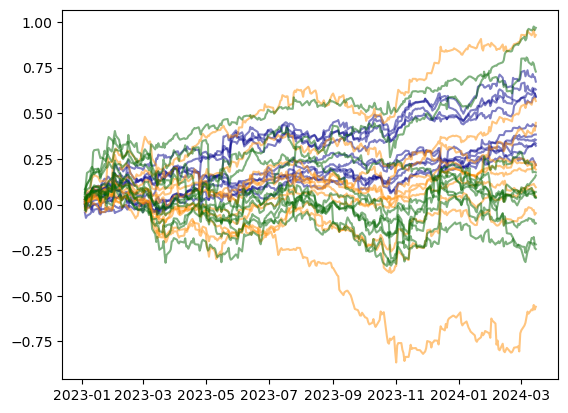

In [200]:
plt.plot(data_test.pct_change()[top10_index1].cumsum(), color = 'darkblue', alpha = 0.5)
plt.plot(data_test.pct_change()[mid10_index1].cumsum(), color = 'darkorange', alpha = 0.5)
plt.plot(data_test.pct_change()[bottom10_index1].cumsum(), color = 'darkgreen', alpha = 0.5)
plt.show()

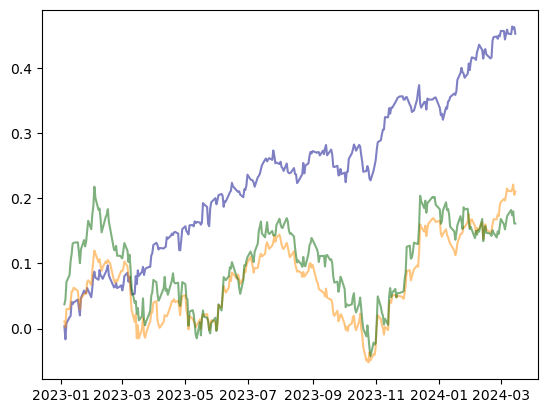

In [201]:
plt.plot(data_test.pct_change()[top10_index1].mean(axis = 1).cumsum(), color = 'darkblue', alpha = 0.5, label = 'top20')
plt.plot(data_test.pct_change()[mid10_index1].mean(axis = 1).cumsum(), color = 'darkorange', alpha = 0.5, label = 'mid20')
plt.plot(data_test.pct_change()[bottom10_index1].mean(axis = 1).cumsum(), color = 'darkgreen', alpha = 0.5, label = 'bottom20')
plt.show()

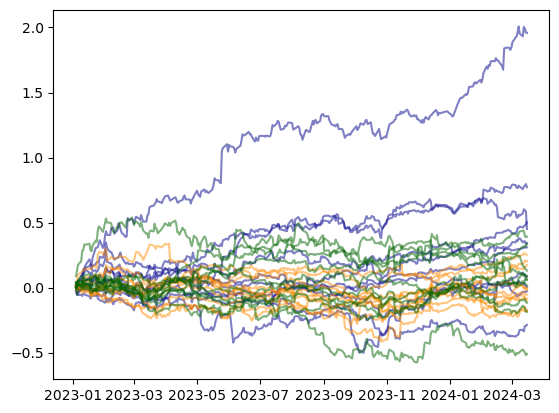

In [202]:
plt.plot(data_test.pct_change()[top10_index2].cumsum(), color = 'darkblue', alpha = 0.5)
plt.plot(data_test.pct_change()[mid10_index2].cumsum(), color = 'darkorange', alpha = 0.5)
plt.plot(data_test.pct_change()[bottom10_index2].cumsum(), color = 'darkgreen', alpha = 0.5)
plt.show()

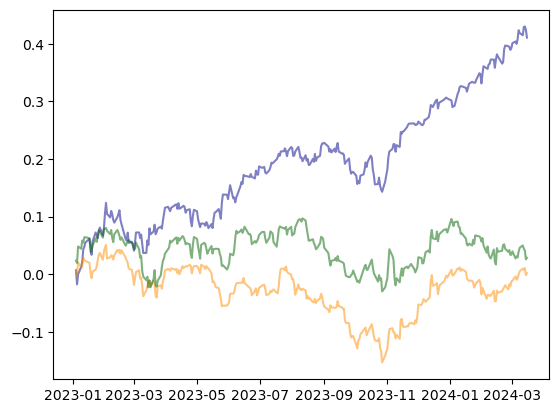

In [204]:
plt.plot(data_test.pct_change()[top10_index2].mean(axis = 1).cumsum(), color = 'darkblue', alpha = 0.5, label = 'top20')
plt.plot(data_test.pct_change()[mid10_index2].mean(axis = 1).cumsum(), color = 'darkorange', alpha = 0.5, label = 'mid20')
plt.plot(data_test.pct_change()[bottom10_index2].mean(axis = 1).cumsum(), color = 'darkgreen', alpha = 0.5, label = 'bottom20')
plt.show()

Portfolio

In [205]:
top10_index1

Index(['MSFT', 'CTAS', 'SNPS', 'MSCI', 'CPRT', 'CDNS', 'AJG', 'RSG', 'BRO',
       'MA'],
      dtype='object', name='Ticker')

In [206]:
data[top10_index1]

Ticker            MSFT        CTAS        SNPS        MSCI       CPRT  \
Date                                                                    
2015-01-02   46.759998   78.449997   43.099998   47.689999   4.572500   
2015-01-05   46.330002   77.019997   42.540001   47.240002   4.527500   
2015-01-06   45.650002   76.870003   42.160000   48.610001   4.476250   
2015-01-07   46.230000   76.470001   42.209999   49.720001   4.490000   
2015-01-08   47.590000   77.730003   42.860001   51.220001   4.536250   
...                ...         ...         ...         ...        ...   
2022-12-23  238.729996  457.239990  320.209991  463.820007  30.254999   
2022-12-27  236.960007  459.029999  317.950012  460.429993  30.045000   
2022-12-28  234.529999  451.040009  315.309998  454.440002  29.980000   
2022-12-29  241.009995  456.950012  321.980011  471.920013  30.615000   
2022-12-30  239.820007  451.619995  319.290009  465.170013  30.445000   

Ticker            CDNS         AJG         RSG        BRO          MA  
Date                                                                   
2015-01-02   18.830000   46.980000   40.570000  16.280001   85.680000  
2015-01-05   18.400000   46.700001   40.340000  16.070000   83.269997  
2015-01-06   17.910000   46.610001   40.480000  15.990000   83.089996  
2015-01-07   18.420000   47.060001   40.340000  16.135000   84.220001  
2015-01-08   18.610001   47.880001   40.709999  16.445000   85.529999  
...                ...         ...         ...        ...         ...  
2022-12-23  161.449997  188.410004  130.770004  56.939999  343.600006  
2022-12-27  160.050003  189.279999  130.919998  57.360001  346.160004  
2022-12-28  158.339996  187.949997  129.410004  56.570000  341.950012  
2022-12-29  161.929993  190.169998  130.750000  57.650002  348.209991  
2022-12-30  160.639999  188.539993  128.990005  56.970001  347.730011  

[2014 rows x 10 columns]

In [207]:
from FinancialMachineLearning.portfolio_optimization.historical_risk_parity import HierarchicalRiskParity

hrp = HierarchicalRiskParity()
hrp.allocate(
    asset_names = top10_index1, 
    asset_prices = data[top10_index1], 
    asset_returns = data[top10_index1].pct_change().fillna(0)
)
hrp_weights = hrp.weights.sort_values(by = 0, ascending = False, axis = 1)
hrp_weights

Ticker       RSG      AJG      CPRT        MA     MSFT       BRO      MSCI  \
0       0.232841  0.14375  0.114167  0.097578  0.09382  0.086478  0.083948   

Ticker      CTAS      SNPS      CDNS  
0       0.059774  0.047453  0.040189

In [237]:
hrp_weights.columns

Index(['RSG', 'AJG', 'CPRT', 'MA', 'MSFT', 'BRO', 'MSCI', 'CTAS', 'SNPS',
       'CDNS'],
      dtype='object', name='Ticker')

In [218]:
portfolio_cluster1 = data_test[hrp_weights.columns].pct_change().fillna(0) * hrp_weights.values

In [224]:
backtest_cluster1 = portfolio_cluster1.sum(axis = 1)

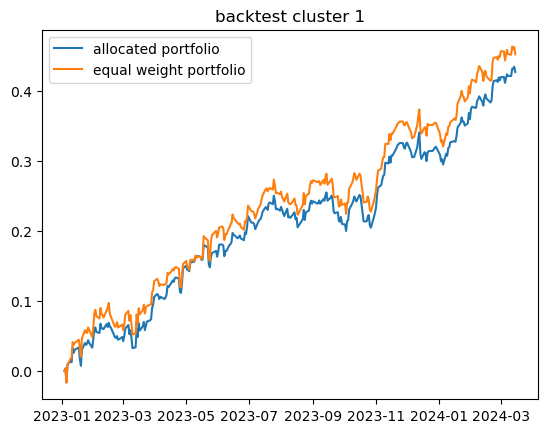

In [234]:
plt.plot(
    backtest_cluster1.cumsum(),
    label = 'allocated portfolio'
)
plt.plot(
    data_test[hrp_weights.columns].pct_change().fillna(0).mean(axis = 1).cumsum(),
    label = 'equal weight portfolio'
)
plt.title('backtest cluster 1')
plt.legend()
plt.show()

In [227]:
hrp2 = HierarchicalRiskParity()
hrp2.allocate(
    asset_names = top10_index2, 
    asset_prices = data[top10_index2], 
    asset_returns = data[top10_index2].pct_change().fillna(0)
)
hrp_weights2 = hrp2.weights.sort_values(by = 0, ascending = False, axis = 1)
hrp_weights2

Ticker       PGR        WM       UNH       TMO       NEE      POOL      AMZN  \
0       0.170071  0.156408  0.146254  0.116362  0.106388  0.100996  0.092952   

Ticker      EPAM      ADBE      NVDA  
0       0.045206  0.044548  0.020814

In [228]:
portfolio_cluster2 = data_test[hrp_weights2.columns].pct_change().fillna(0) * hrp_weights2.values
backtest_cluster2 = portfolio_cluster2.sum(axis = 1)

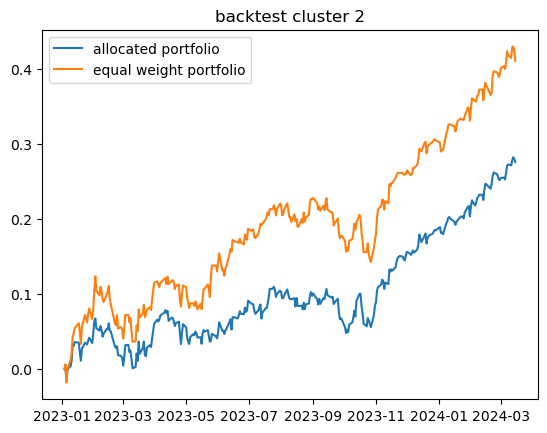

In [236]:
plt.plot(
    backtest_cluster2.cumsum(),
    label = 'allocated portfolio'
)
plt.plot(
    data_test[hrp_weights2.columns].pct_change().fillna(0).mean(axis = 1).cumsum(),
    label = 'equal weight portfolio'
)
plt.title('backtest cluster 2')
plt.legend()
plt.show()

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd

tickers = ['RSG', 'AJG', 'CPRT', 'MA', 'MSFT', 'BRO', 'MSCI', 'CTAS', 'SNPS', 'CDNS']

data = yf.download(tickers, start = '2024-03-16', end = '2024-04-15')['Adj Close']

[*********************100%%**********************]  10 of 10 completed


In [3]:
ret = data.pct_change().dropna()

<Axes: xlabel='Date'>

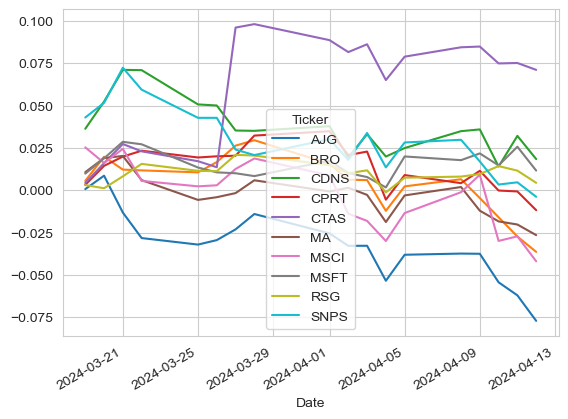

In [10]:
ret.cumsum().plot()